In [239]:
import pandas as pd
import altair as alt
from prophet import Prophet
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns
import mplfinance as mpf
import stumpy
import math
import numpy as np
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [240]:
html = open('gme2.html', 'r').read()

In [241]:
soup = BeautifulSoup(html, 'html.parser')
headers = [header.get_text(strip=True) for header in soup.find_all('th')]
rows = []
for row in soup.find_all('tr')[1:]:
    cols = [col.get_text(strip=True) for col in row.find_all('td')]
    rows.append(cols)
headers[4] = headers[4][:5]
headers[5] = headers[5][:9]
print(headers)

['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']


In [242]:
df = pd.DataFrame(rows, columns=headers)
df = df.iloc[::-1].reset_index(drop=True)
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,"Jan 03, 2017",6.34,6.36,6.37,6.25,7.77M,+0.32%
1,"Jan 04, 2017",6.48,6.39,6.51,6.39,8.98M,+2.21%
2,"Jan 05, 2017",6.25,6.39,6.39,6.22,12.15M,-3.55%
3,"Jan 06, 2017",6.13,6.29,6.29,6.12,9.34M,-1.92%
4,"Jan 09, 2017",6.12,6.15,6.17,6.08,6.59M,-0.16%


In [243]:
df['Date'] = pd.to_datetime(df['Date'])
df['Open'] = pd.to_numeric(df['Open'],errors='coerce')
df['High'] = pd.to_numeric(df['High'],errors='coerce')
df['Price'] = pd.to_numeric(df['Price'],errors='coerce')
df['Low'] = pd.to_numeric(df['Low'],errors='coerce')
def convert_volume(volume):
    if 'M' in volume:
        return float(volume.replace('M', '')) * 1_000_000
    elif 'B' in volume:
        return float(volume.replace('B', '')) * 1_000_000_000
    else:
        return float(volume)
df['Vol.'] = df['Vol.'].apply(convert_volume)
df['Change %'] = df['Change %'].str.replace('%', '', regex=False).astype(float)
# df.sort_values(by='Date', inplace=True)
df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
1084,2021-04-26,42.23,37.74,43.67,37.19,42130000.0,11.74
1085,2021-04-27,44.44,45.89,47.00,43.29,35730000.0,5.23
1086,2021-04-28,44.65,43.03,45.49,41.51,23160000.0,0.46
1087,2021-04-29,44.05,44.14,45.22,42.69,15040000.0,-1.34
1088,2021-04-30,43.40,43.75,45.95,43.17,17730000.0,-1.48


In [244]:
df = df.dropna()

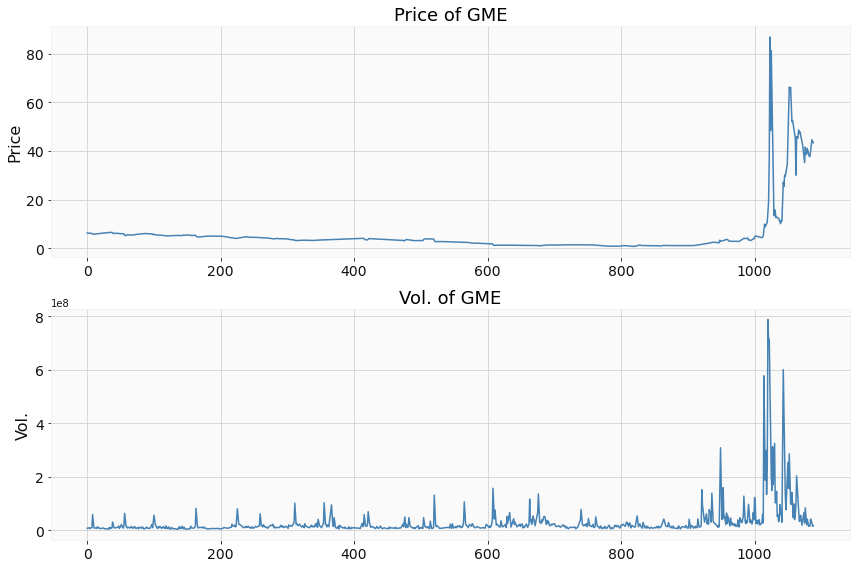

In [323]:
price_volume = df[['Price', 'Vol.']]  
num_columns = price_volume.shape[1] 
plt.figure(figsize=(12, 8))  
for num, col in enumerate(price_volume.columns, start=1):
    plt.subplot(num_columns, 1, num)  
    price_volume[col].plot(color = 'steelblue')  
    plt.ylabel(col, fontsize = 16)  
    plt.xlabel(None) 
    plt.title(f"{col} of GME", fontsize = 18)
    plt.tick_params(axis='x', labelsize=14)
    plt.tick_params(axis='y', labelsize=14)
    plt.tight_layout()  
plt.show()


In [246]:
# ma_day = [10, 20, 50]
# for ma in ma_day:
#     column_name = f"MA for {ma} days"
#     df[column_name] = df['Price'].rolling(ma).mean()

# fig, ax = plt.subplots(figsize=(20, 7))
# df[['Price', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=ax)
# ax.set_title('GME Adjusted Close Price with Moving Averages')
# ax.set_xlabel('Date')
# ax.set_ylabel('Price')

# plt.show()

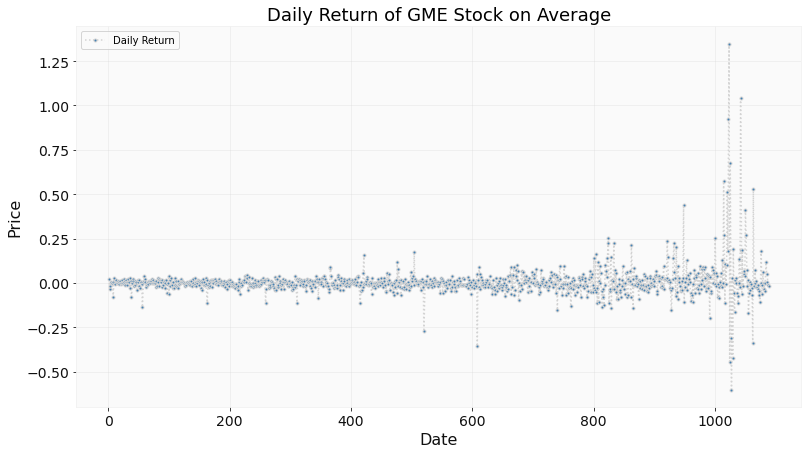

In [320]:
fig, ax = plt.subplots(figsize=(13, 7))
df['Daily Return'] = df['Price'].pct_change()
ax.set_title('Daily Return of GME Stock on Average', fontsize = 18)
ax.set_xlabel('Date', fontsize = 16)
ax.set_ylabel('Price', fontsize = 16)
ax.grid(alpha = .3)
df['Daily Return'].plot(ax=ax, legend=True, linestyle='dotted', marker='.', color='lightgrey', markerfacecolor='steelblue')
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)  

In [248]:
# plt.figure(figsize=(12, 5))
# df['Daily Return'].hist(bins=50)
# plt.xlabel('Daily Return')
# plt.ylabel('Counts')
# plt.title('Daily Return of GME Stock on Average')
# plt.tight_layout()

In [249]:
# mpf.plot(df_price, type='candle', ylabel='Price', ylabel_lower='Volume($)', figratio=(16, 6),style = 'yahoo', volume = True, mav = (50, 100))

----
## Here begins outlier detection

In [250]:
def convert_date_format(date_str):
    date_obj = datetime.strptime(date_str, "%b %d, %Y")
    return date_obj.strftime("%m/%d/%Y")
date_str = "Jan 03, 2017"
new_date_format = convert_date_format(date_str)
print(new_date_format)

01/03/2017


In [251]:
gme_df = pd.DataFrame(rows, columns=headers)
columns_to_drop = ['Open', 'High', 'Low', 'Vol.', 'Change %']
gme_df.drop(columns=columns_to_drop, inplace=True)
gme_df = gme_df.iloc[::-1]
gme_df = gme_df.rename(columns = {'Date': 'ds', 'Price': 'y'})
gme_df['ds'] = gme_df['ds'].apply(lambda x: convert_date_format(x))
gme_df['ds'] = pd.to_datetime(gme_df['ds'])
gme_df['y'] = gme_df['y'].astype(float)
display(gme_df)

,ds,y
1088,2017-01-03,6.34
1087,2017-01-04,6.48
1086,2017-01-05,6.25
1085,2017-01-06,6.13
1084,2017-01-09,6.12
...,...,...
4,2021-04-26,42.23
3,2021-04-27,44.44
2,2021-04-28,44.65
1,2021-04-29,44.05


### Prophet

In [253]:
m = Prophet(daily_seasonality= False, weekly_seasonality= False,
            yearly_seasonality= False, seasonality_mode= 'additive',
            interval_width = .95, changepoint_range= .9, growth = 'linear')
m.fit(gme_df)
forecast = m.predict(gme_df)
forecast['real_value'] = gme_df['y'].reset_index(drop = True)

10:11:58 - cmdstanpy - INFO - Chain [1] start processing
10:11:58 - cmdstanpy - INFO - Chain [1] done processing


In [254]:
forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'real_value']].copy()

forecasted['anomaly'] = 0
forecasted.loc[forecasted['real_value'] > forecasted['yhat_upper'], 'anomaly'] = 1
forecasted.loc[forecasted['real_value'] < forecasted['yhat_lower'], 'anomaly'] = -1

forecasted['importance'] = 0
forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
    (forecasted['real_value'] - forecasted['yhat_upper'])/forecast['real_value']
forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
    (forecasted['yhat_lower'] - forecasted['real_value'])/forecast['real_value']
forecasted

,ds,trend,yhat,yhat_lower,yhat_upper,real_value,anomaly,importance
0,2017-01-03,6.238566,6.238566,-2.666094,15.205428,6.34,0,0.0
1,2017-01-04,6.233814,6.233814,-2.331282,14.893524,6.48,0,0.0
2,2017-01-05,6.229062,6.229062,-2.113675,14.494229,6.25,0,0.0
3,2017-01-06,6.224311,6.224311,-2.338843,14.597799,6.13,0,0.0
4,2017-01-09,6.210055,6.210055,-2.498178,14.576969,6.12,0,0.0
...,...,...,...,...,...,...,...,...
1084,2021-04-26,47.809099,47.809099,38.726350,56.527361,42.23,0,0.0
1085,2021-04-27,48.104860,48.104860,39.539021,56.541859,44.44,0,0.0
1086,2021-04-28,48.400621,48.400621,39.127790,56.618506,44.65,0,0.0
1087,2021-04-29,48.696381,48.696381,39.716688,57.427511,44.05,0,0.0


In [365]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = 'lightgrey').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'real_value', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
      #  title='GME Anomaly Detection using Prophet'
    )

    real_value = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=10, opacity=1, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('real_value', title='Sales'),    
        tooltip=['ds', 'real_value', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly!=0]).mark_circle(size=0.01, color = 'steelblue').encode(
        x='ds:T',
        y=alt.Y('real_value', title='Sales'),    
        tooltip=['ds', 'real_value', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, real_value, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=10)
              
plot_anomalies(forecasted)

alt.LayerChart(...)

### Isolation forest

In [225]:
gme_df = gme_df.drop('ds', axis = 1)

In [226]:
gme_df = gme_df.reset_index(drop = True)

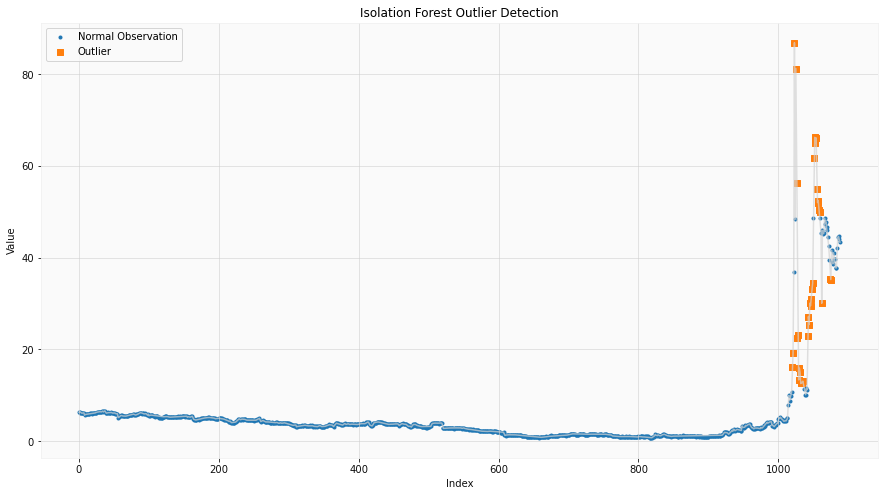

In [297]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42, bootstrap=True, contamination = 0.03)  
isolation_forest.fit(gme_df)
outliers = isolation_forest.predict(gme_df)
plt.figure(figsize = (15, 8))
plt.scatter(np.where(outliers == 1)[0], gme_df[outliers == 1], label='Normal Observation', marker='.')
plt.scatter(np.where(outliers == -1)[0], gme_df[outliers == -1],label='Outlier', marker=',')
plt.plot(gme_df, color = 'lightgrey', alpha = .7)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Isolation Forest Outlier Detection')
plt.grid(alpha = 0.7)
plt.legend(['Normal Observation', 'Outlier'], loc = 'upper left')
plt.show()

fail

### Spatial

In [353]:
from KDEpy import FFTKDE
from sklearn.preprocessing import MinMaxScaler
from scipy.interpolate import interp1d

In [354]:
gme = pd.DataFrame(rows, columns=headers)
columns_to_drop = ['Open', 'High', 'Low', 'Vol.', 'Change %']
gme.drop(columns=columns_to_drop, inplace=True)
gme['Date'] = pd.to_datetime(gme['Date'])
gme['Price'] = gme['Price'].astype(float)
gme.set_index('Date', inplace = True)
gme = gme.iloc[::-1]
display(gme)

,Price
Date,
2017-01-03,6.34
2017-01-04,6.48
2017-01-05,6.25
2017-01-06,6.13
2017-01-09,6.12
...,...
2021-04-26,42.23
2021-04-27,44.44
2021-04-28,44.65


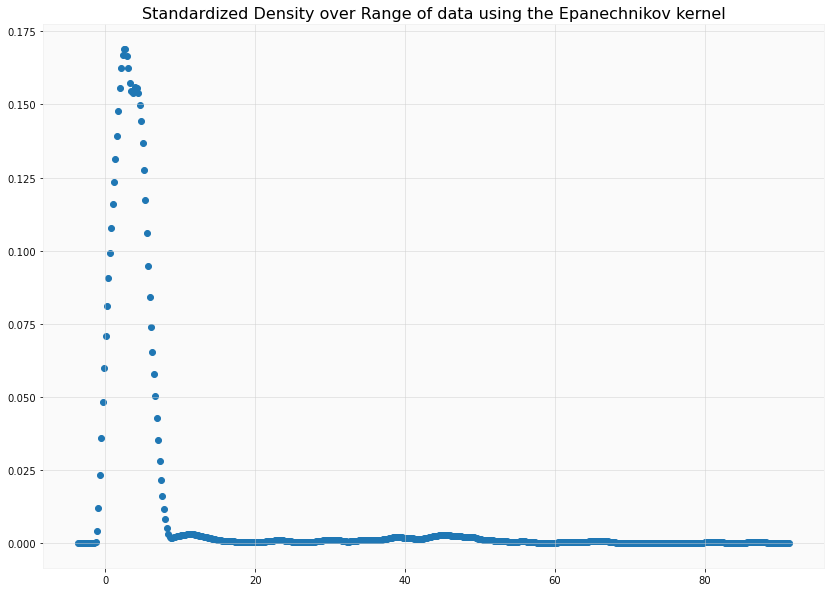

In [355]:
estimator = FFTKDE(kernel='epa') #Epanechnikov kernel
density_grid = estimator.fit(gme.values).evaluate(500)
standardized_density = MinMaxScaler().fit_transform(density_grid[1].reshape(-1,1))
grid_range = density_grid[0]

plt.figure(figsize=(14,10))
plt.title("Standardized Density over Range of data using the Epanechnikov kernel", fontsize = 16)
plt.scatter(x=grid_range, y=density_grid[1])
plt.grid(alpha = .6)

In [356]:
density_model = interp1d(
    x=grid_range, 
    y=standardized_density.ravel(), 
    bounds_error=False,
    fill_value=0)

gme_anomalies_spatial = pd.DataFrame(index=gme.index, data=density_model(gme) < 0.01)

In [357]:
gme_density = pd.merge(gme, gme_anomalies_spatial, on='Date', how='left')
gme_density = gme_density.rename(columns={0: 'Anomalies'})
gme_density

,Price,Anomalies
Date,,
2017-01-03,6.34,False
2017-01-04,6.48,False
2017-01-05,6.25,False
2017-01-06,6.13,False
2017-01-09,6.12,False
...,...,...
2021-04-26,42.23,True
2021-04-27,44.44,False
2021-04-28,44.65,False


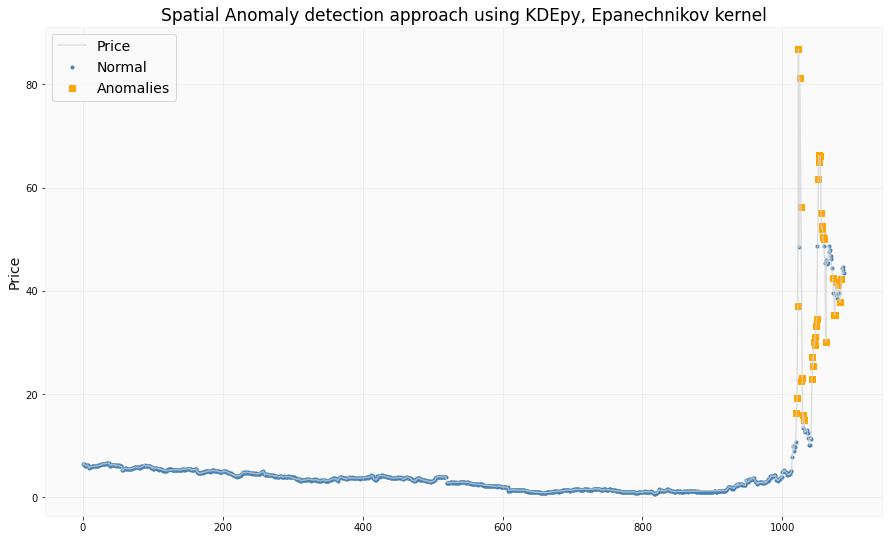

In [363]:
anomalies_true = gme_density[gme_density['Anomalies'] == True]
anomalies_false = gme_density[gme_density['Anomalies'] == False]

plt.figure(figsize=(15, 9))
plt.plot(gme['Price'].reset_index(drop = True), color = 'lightgrey', alpha = .7)
plt.scatter(np.where(gme_density['Anomalies'] == False), anomalies_false['Price'], color='steelblue', marker='.')
plt.scatter(np.where(gme_density['Anomalies'] == True),anomalies_true['Price'], color='orange', marker=',')

plt.title('Spatial Anomaly detection approach using KDEpy, Epanechnikov kernel', fontsize = 17)
plt.ylabel('Price', fontsize = 14)
plt.legend(['Price', 'Normal', 'Anomalies'], fontsize = 14)
plt.grid(alpha = .3)
plt.show()

In [359]:
gme_density_recent = gme_density[1000:]

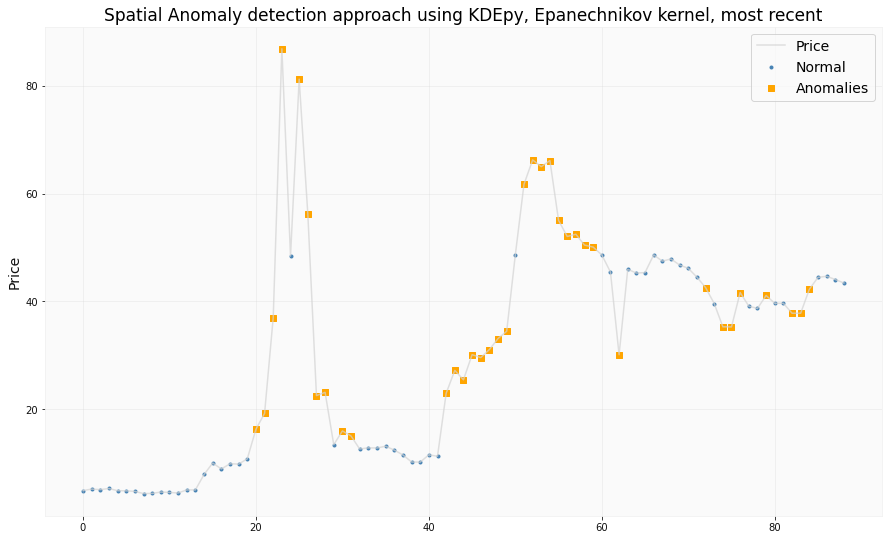

In [364]:
anomalies_true = gme_density_recent[gme_density_recent['Anomalies'] == True]
anomalies_false = gme_density_recent[gme_density_recent['Anomalies'] == False]

plt.figure(figsize=(15, 9))
plt.plot(gme['Price'][1000:].reset_index(drop=True), color='lightgrey', alpha = .7)
plt.scatter(np.where(gme_density_recent['Anomalies'] == False), anomalies_false['Price'], color='steelblue', marker='.')
plt.scatter(np.where(gme_density_recent['Anomalies'] == True), anomalies_true['Price'], color='orange', marker=',')

plt.title('Spatial Anomaly detection approach using KDEpy, Epanechnikov kernel, most recent', fontsize = 17)
plt.ylabel('Price', fontsize = 14)
plt.legend(['Price', 'Normal', 'Anomalies'], fontsize = 14)
plt.grid(alpha=0.3)
plt.show()

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>],
      dtype=object)

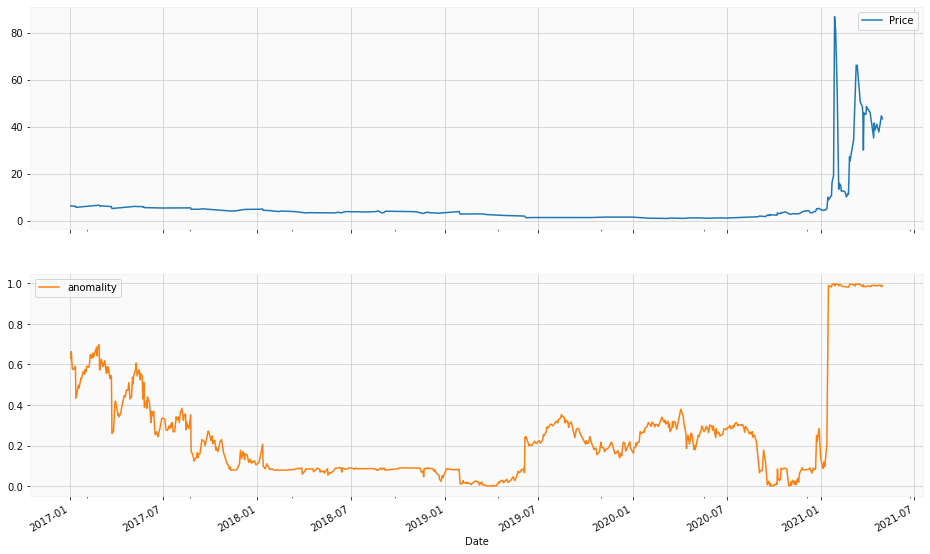

In [361]:
estimator = FFTKDE(kernel='epa')
density_grid = estimator.fit(gme.values).evaluate(1000)
standardized_density = 1 - MinMaxScaler().fit_transform(density_grid[1].reshape(-1,1))
grid_range = density_grid[0]

density_model = interp1d(
    x=grid_range, 
    y=standardized_density.ravel(), 
    bounds_error=False,
    fill_value=0)

gme["anomality"] = density_model(gme)
gme.plot(subplots=True, figsize=(16,10))
